# 2DSegmentNet-v2
* In V2 we try to extend 2D so image where we have both x,y as input.
* NOT NEEDED - We use ymin, ymax to initialize y model parameters. 
* NOT NEEDED - We create a mask so that only the tiered segments (for same x) that fall in yact range are actually used to predict y.
* NOT NEEDED - This means we not only know how many ys we need ot predict (out_features) we also kind of know the y but only use it to create mask?

* next step - try with a BW image. 


## Initialization

In [6]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Download MNIST image

In [686]:
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

train_set = datasets.MNIST('data', train=True, download=True, transform=transform)

In [690]:
# get 1st image
index = 0
# Get the image and its corresponding label
image, label = train_set[index]
image.shape

torch.Size([28, 28])

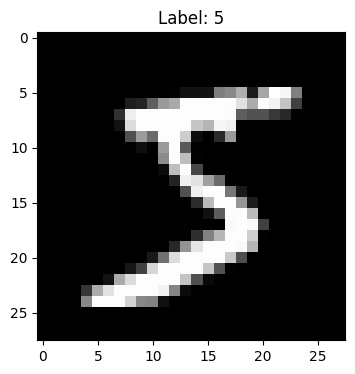

In [689]:
# display MNST image
import matplotlib.pyplot as plt

plt.imshow(image.squeeze().numpy(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

# Image we are trying to approximate

Image shape: (427, 640, 3)


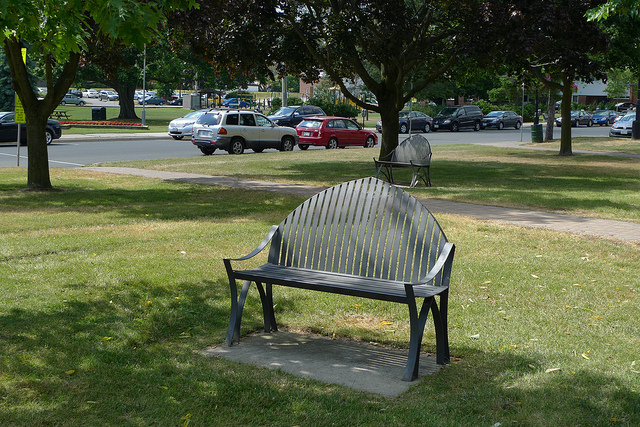

In [237]:
# load demo image and convert it to grayscale and BW image
from PIL import Image

# Load the image
image = Image.open("demo.jpg")
print("Image shape:",np.array(image).shape)
display(image)

grayscale_image shape: (427, 640)


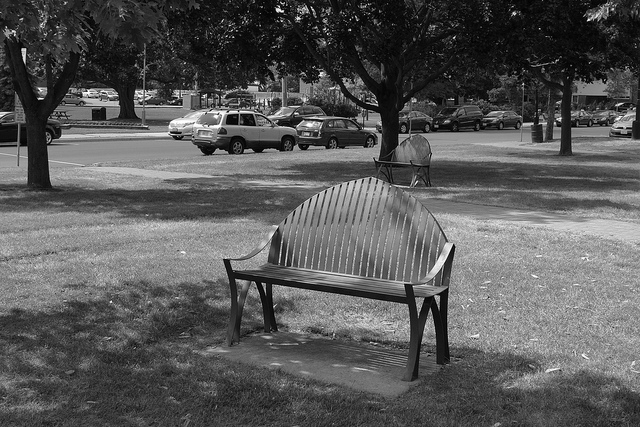

In [239]:
# Convert the image to grayscale
grayscale_image = image.convert("L")

# Display the grayscale image
print("grayscale_image shape:",np.array(grayscale_image).shape)
display(grayscale_image)

# Visualizing image at various grayscale depth

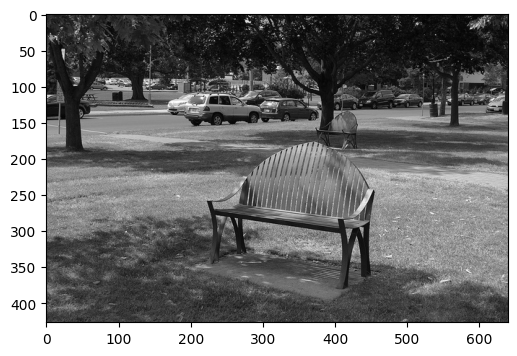

In [273]:
# Get the image data as a NumPy array
grayscale_array = np.array(grayscale_image)
plt.imshow(grayscale_image, cmap="gray")
plt.show()

mean grayscale pixel value: 88.23072672716627


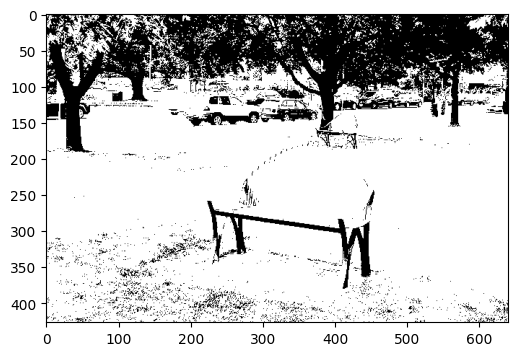

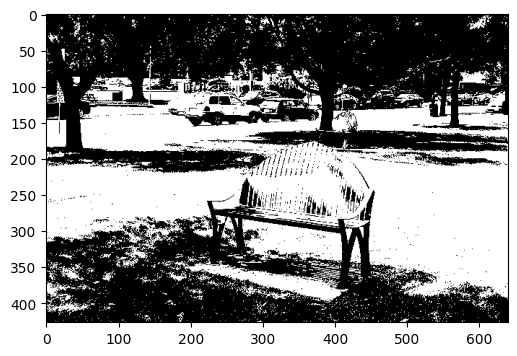

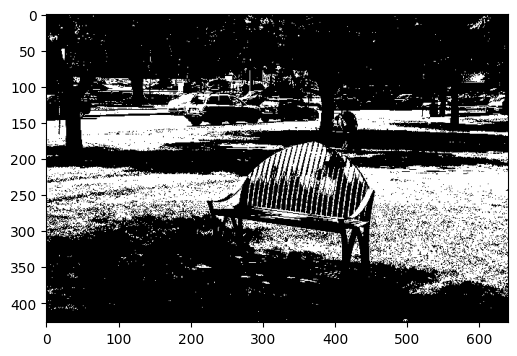

In [317]:
print("mean grayscale pixel value:",grayscale_array.mean())

#Create a bw_array by converting image to binary around a grayscale value
limit = grayscale_array.mean()*1./2.
bw_array  = torch.tensor(np.where(grayscale_array < limit, 0, 1))
#Visualize it
axesImage = plt.imshow(bw_array, cmap="gray")
plt.show()

limit = grayscale_array.mean()
bw_array  = torch.tensor(np.where(grayscale_array < limit, 0, 1))
#Visualize it
axesImage = plt.imshow(bw_array, cmap="gray")
plt.show()

limit = grayscale_array.mean()*3./2.
bw_array  = torch.tensor(np.where(grayscale_array < limit, 0, 1))
#Visualize it
axesImage = plt.imshow(bw_array, cmap="gray")
plt.show()


# Converting binary image data to x,y 

In [657]:
bw_array  = torch.tensor(np.where(grayscale_array < grayscale_array.mean(), 0, 1))
print(bw_array.shape)
ymax = bw_array.shape[0]
print(ymax)
#create position matrix from binary
y = bw_array.T*torch.arange(ymax)
print(y.shape)
#print(y[0])
xmax = bw_array.shape[1]
x = bw_array*torch.arange(xmax).T
print("x shape",x.shape)
print(x[-1])

torch.Size([427, 640])
427
torch.Size([640, 427])
x shape torch.Size([427, 640])
tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,  15,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  90,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 109,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 151,   0,   0,
          0,   0,   0,   0, 158,   0,   0,   0,   0,   0,   0

In [658]:
# Create segment range - normally from model.y but for now linspace
y_min = y.min()
y_max = y.max()
out_features = 4
y_init = torch.Tensor(np.linspace(y_min, y_max, out_features + 1))
print(y_init)


tensor([  0.0000, 106.5000, 213.0000, 319.5000, 426.0000])


In [659]:
#We need to average y to fit y_init segments
# try with one column then expand.
y0 = y[0]
lt = torch.lt(y0.unsqueeze(1),y_init[1:])
ge = torch.ge(y0.unsqueeze(1),y_init[:-1])
mask = (lt & ge)
print(mask.shape)
print(y0[180:190])
print(mask[180:190])
y0m = y0.to(torch.float32)*mask.T
print(y0m.shape)
print(y0m[:,180:190])
print(y0m.sum(dim=1))
print(y0m.count_nonzero(dim=1))

yact = y0m.sum(dim=1)/y0m.count_nonzero(dim=1)
print(yact.shape, yact)

torch.Size([427, 4])
tensor([180, 181, 182, 183,   0,   0,   0,   0,   0,   0])
tensor([[False,  True, False, False],
        [False,  True, False, False],
        [False,  True, False, False],
        [False,  True, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False]])
torch.Size([4, 427])
tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [180., 181., 182., 183.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])
tensor([  536., 10509., 26881.,  9837.])
tensor([ 10,  63, 102,  26])
torch.Size([4]) tensor([ 53.6000, 166.8095, 263.5392, 378.3462])


In [667]:
y_2dinit = torch.Tensor(6, out_features + 1)
print(y.shape, y_2dinit.shape)
y_2dinit[:] = y_init.unsqueeze(0)
#print(y_init,"\n", y_2dinit[0:2,:])
ynd = y.unsqueeze(2).unsqueeze(2)
print(ynd.shape, y_2dinit[:,1:].shape)
#fit/average y to y_2dinit
lt = torch.lt(ynd, y_2dinit[:,1:])
ge = torch.ge(ynd, y_2dinit[:,:-1])
mask = (lt & ge)
mask_lt = torch.lt(ynd, y_2dinit[:,0:1])
mask_ge = torch.ge(ynd, y_2dinit[:,-1:])
# then do OR with mask so these are included for prediction.
mask[:,:,:,-1:] = mask[:,:,:,-1:] | mask_ge
mask[:,:,:, :1] = mask[:,:,:, :1] | mask_lt
print(mask.shape)
print(y[300:310,10])
print(mask[300:310,10,:,:])



torch.Size([640, 427]) torch.Size([6, 5])
torch.Size([640, 427, 1, 1]) torch.Size([6, 4])
torch.Size([640, 427, 6, 4])
tensor([10, 10, 10, 10, 10, 10, 10, 10, 10,  0])
tensor([[[ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False]],

        [[ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False]],

        [[ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False]],

        [[ True, False, False, False],
         [ True, False, False, False],
         [ True, False, False, False],
       

In [602]:
# Create 2d y_init
y_2dinit = torch.Tensor(y.shape[1], out_features + 1)
print(y.shape, y_2dinit.shape)
y_2dinit[:] = y_init.unsqueeze(0)
print(y_init,"\n", y_2dinit[0:2,:])

#fit/average y to y_2dinit
lt = torch.lt(y.unsqueeze(2), y_2dinit[:,1:])
ge = torch.ge(y.unsqueeze(2), y_2dinit[:,:-1])
mask = (lt & ge)
print(y.shape, mask.shape)
#take care of edge cases
mask_lt = torch.lt(y.unsqueeze(2), y_2dinit[:,0:1])
mask_ge = torch.ge(y.unsqueeze(2), y_2dinit[:,-1:])
# then do OR with mask so these are included for prediction.
mask[:,:,-1:] = mask[:,:,-1:] | mask_ge
mask[:,:, :1] = mask[:,:, :1] | mask_lt
# Apply mask to Y after making sure dimensions match with the mask.
ym = y.unsqueeze(2)*mask
# We need to average out the column so we get the yact with shape [x.length,out_features]
yact = ym.sum(dim=1)/ym.count_nonzero(dim=1)
print(yact.shape)

#print(lt.shape)
#print(lt[0,1,:])

# test passed
print(y[300:310,10])
#print(y_2dinit[240,:])
#print(lt[0,240:250,:])
#print(ge[0,240:250,:])
print(mask[300:310,10,:])
#print(ym[0:10,0,:])
#print(yact[0:10,:])


torch.Size([640, 427]) torch.Size([427, 5])
tensor([  0.0000, 106.5000, 213.0000, 319.5000, 426.0000]) 
 tensor([[  0.0000, 106.5000, 213.0000, 319.5000, 426.0000],
        [  0.0000, 106.5000, 213.0000, 319.5000, 426.0000]])
torch.Size([640, 427]) torch.Size([640, 427, 4])
torch.Size([640, 4])
tensor([10, 10, 10, 10, 10, 10, 10, 10, 10,  0])
tensor([[ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False],
        [ True, False, False, False]])


In [475]:
# EXPERIMENT TO UNDERSTAND
x_in = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])
x_in = torch.tensor(x_in.reshape(x_in.shape[0],1), dtype=torch.float32)
x = torch.Tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])
print(x_in.shape, x.shape)
lt = torch.lt(x_in, x[:, 1:]) 
print(lt.shape)
print(lt)


torch.Size([9, 1]) torch.Size([1, 7])
torch.Size([9, 6])
tensor([[ True,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True],
        [False,  True,  True,  True,  True,  True],
        [False, False,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False,  True,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False,  True,  True],
        [False, False, False, False, False,  True]])


In [541]:
# EXPERIMENT converted to two rows
x_in = torch.tensor(np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9]))
x_2din = torch.Tensor(x_in.shape[0],2)
x_2din[:] = x_in.unsqueeze(1)
print(x_2din)
print(x_2din.shape)
x_init = torch.Tensor([0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000])
x_init2d = torch.Tensor(2, x_init.shape[0])
x_init2d[:] = x_init.unsqueeze(0)
print(x_init.shape, x_init2d.shape)
print(x_init2d)
lt = torch.lt(x_2din.unsqueeze(2), x_init2d[:, 1:]) 
print(lt.shape)
print(lt)



tensor([[0.1000, 0.1000],
        [0.2000, 0.2000],
        [0.3000, 0.3000],
        [0.4000, 0.4000],
        [0.5000, 0.5000],
        [0.6000, 0.6000],
        [0.7000, 0.7000],
        [0.8000, 0.8000],
        [0.9000, 0.9000]])
torch.Size([9, 2])
torch.Size([7]) torch.Size([2, 7])
tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000],
        [0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])
torch.Size([9, 2, 6])
tensor([[[ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True]],

        [[False,  True,  True,  True,  True,  True],
         [False,  True,  True,  True,  True,  True]],

        [[False,  True,  True,  True,  True,  True],
         [False,  True,  True,  True,  True,  True]],

        [[False, False,  True,  True,  True,  True],
         [False, False,  True,  True,  True,  True]],

        [[False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True]],

        [[False,

In [547]:
import torch

tensor1 = torch.Tensor(
        [[0.1000, 0.4000],
        [0.2000, 0.4000],
        [0.3000, 0.4000],
        [0.4000, 0.4000],
        [0.5000, 0.5000],
        [0.6000, 0.6000],
        [0.7000, 0.7000],
        [0.8000, 0.8000],
        [0.9000, 0.9000]])
tensor2 = torch.Tensor([
        [0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000],
        [0.0000, 0.222, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])

# Create the less-than mask using broadcasting:
mask = (tensor1.unsqueeze(2) < tensor2[:,1:]).bool()  # Unsqueeze to match dimensions

print(mask)


tensor([[[ True,  True,  True,  True,  True,  True],
         [False, False,  True,  True,  True,  True]],

        [[False,  True,  True,  True,  True,  True],
         [False, False,  True,  True,  True,  True]],

        [[False,  True,  True,  True,  True,  True],
         [False, False,  True,  True,  True,  True]],

        [[False, False,  True,  True,  True,  True],
         [False, False,  True,  True,  True,  True]],

        [[False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True]],

        [[False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True]],

        [[False, False, False, False,  True,  True],
         [False, False, False, False,  True,  True]],

        [[False, False, False, False,  True,  True],
         [False, False, False, False,  True,  True]],

        [[False, False, False, False, False,  True],
         [False, False, False, False, False,  True]]])


# Model definition

## model test dev

In [47]:
# Test - how to initialize 2D x array with same values 
segment_features = 6
out_features = 2
x_init = torch.arange(0, 1 + 1./segment_features, 1./segment_features)
# make sure x_init shape is segment + 1 as it can be more for some segment_features like 6
x_init = x_init[0:1+segment_features]
x_2dinit = torch.Tensor(out_features, segment_features + 1)
x_2dinit[:] = x_init.unsqueeze(0)
x = torch.Tensor(x_2dinit)
print(x.shape, x_init.unsqueeze(0).shape)
# slightly modify second row
if(out_features > 1):
    x[1, 1:-1] = x[1, 1:-1] + .1
print(x)

torch.Size([2, 7]) torch.Size([1, 7])
tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000],
        [0.0000, 0.2667, 0.4333, 0.6000, 0.7667, 0.9333, 1.0000]])


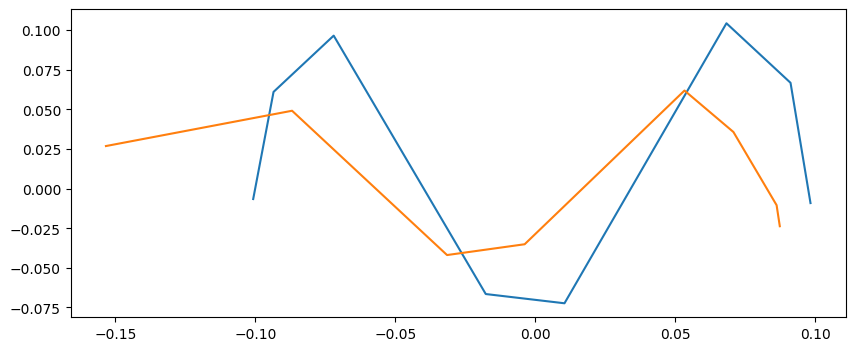

In [95]:
#initializing y
with torch.no_grad():
    plt.plot(model.x[0], model.y[0])
    plt.plot(model.x[1], model.y[1])

In [ ]:
x_in = np.array([.1, .2, .3, .4, .5, .6, .7, .8, .9])
x_in = torch.tensor(x_in.reshape(x_in.shape[0],1), dtype=torch.float32)
x_in.shape

torch.Size([9, 1])

In [49]:
y_init = torch.Tensor(np.linspace(ytest.min(), ytest.max(), out_features))
print(y_init)
print(y_init.unsqueeze(1))

tensor([-0.2915,  0.1002])
tensor([[-0.2915],
        [ 0.1002]])


In [63]:
model = TwoDSegmentNet(2,7)

In [66]:
#with torch.no_grad():
y2d_init = torch.zeros_like(model.y)
y2d_init[:] = y_init.unsqueeze(1)
print(y2d_init)
model.y = nn.Parameter(y2d_init)
model.y

tensor([[-0.2915, -0.2915, -0.2915, -0.2915, -0.2915, -0.2915, -0.2915, -0.2915],
        [ 0.1002,  0.1002,  0.1002,  0.1002,  0.1002,  0.1002,  0.1002,  0.1002]])


Parameter containing:
tensor([[-0.2915, -0.2915, -0.2915, -0.2915, -0.2915, -0.2915, -0.2915, -0.2915],
        [ 0.1002,  0.1002,  0.1002,  0.1002,  0.1002,  0.1002,  0.1002,  0.1002]],
       requires_grad=True)

In [119]:
#create a mask on y
print(model.y)
tensor1 = model.y
dim0 = (tensor1[1:,:]+tensor1[:-1,:])/2
dim1 = (tensor1[:,1:]+tensor1[:,:-1])/2
print(dim0)

Parameter containing:
tensor([[-0.0065,  0.0611,  0.0966, -0.0665, -0.0723,  0.1044,  0.0668, -0.0091],
        [ 0.0269,  0.0492, -0.0419, -0.0351,  0.0619,  0.0358, -0.0104, -0.0237]],
       requires_grad=True)
tensor([[ 0.0102,  0.0551,  0.0274, -0.0508, -0.0052,  0.0701,  0.0282, -0.0164]],
       grad_fn=<DivBackward0>)


In [118]:
y[0:4]

tensor([[[-0.0841,  0.0417]],

        [[-0.0759,  0.0420]],

        [[-0.0678,  0.0423]],

        [[-0.0596,  0.0426]]], grad_fn=<SliceBackward0>)

In [ ]:
#forward
lt = torch.lt(x_in.unsqueeze(1).unsqueeze(1), x[:, 1:]) 
ge = torch.ge(x_in.unsqueeze(1).unsqueeze(1), x[:, :-1]) 
mask = (lt & ge)
#print(mask)
y = torch.Tensor(out_features, segment_features + 1)
#y = copy(x)
if(out_features > 1):
    y[0,:] = x[0, :]
    y[1,:] = x[1,:]*2
else:
    y[0,:] = x[0, :]
print ("x=",x)
print("y=",y)
ratio = (y[:,1:]-y[:,:-1])/(x[:,1:]-x[:,:-1])
print("ratio=",ratio)
y_pred = (x_in.unsqueeze(1).unsqueeze(1) -  x[:,:-1])*mask*ratio + mask * y[:,:-1]
print(y_pred.shape, y_pred.sum(dim=3).squeeze(2).shape)
print("ypred=",y_pred.sum(dim=3).squeeze(2))

x= tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])
y= tensor([[0.0000, 0.1667, 0.3333, 0.5000, 0.6667, 0.8333, 1.0000]])
ratio= tensor([[1., 1., 1., 1., 1., 1.]])
torch.Size([9, 1, 1, 6]) torch.Size([9, 1])
ypred= tensor([[0.1000],
        [0.2000],
        [0.3000],
        [0.4000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000]])


## Model 

In [760]:
class ImageSegmentNet(nn.Module):
    def __init__(self, n_xsegments, n_ysegments):
        super(ImageSegmentNet, self).__init__()
        self.n_xsegments = n_xsegments
        self.n_ysegments = n_ysegments

        #Initialize x coordinates between 0-1 so segments are equal size
        self._custom_init(0, 1, 0, 1)

    def _custom_init(self, x_min, x_max, y_min, y_max):
        #Initialize x coordinates between so segments are equal size
        x_init = torch.Tensor(np.linspace(x_min, x_max, self.n_xsegments + 1))
        # make a 2D init tensor
        x_2dinit = torch.Tensor(self.n_ysegments + 1, self.n_xsegments + 1)
        # Update the x_2dinit tensor with the repeated values
        x_2dinit[:] = x_init.unsqueeze(0)
        # initialize all rows of x
        self.x = nn.Parameter(torch.Tensor(x_2dinit))

        y_init = torch.Tensor(np.linspace(y_min, y_max, self.n_ysegments + 1))
        # make a 2D init tensor
        y_2dinit = torch.Tensor(self.n_ysegments + 1, self.n_xsegments + 1)
        # Update the x_2dinit tensor with the repeated values
        y_2dinit[:] = y_init.unsqueeze(1)
        # initialize all rows of y
        self.y = nn.Parameter(torch.Tensor(y_2dinit))

    def set_image(self, image:Image = None, grayscale_array = None):
        if image:
            grayscale_image = image.convert("L")
            grayscale_array = np.array(grayscale_image)
        cutoff = grayscale_array.mean()
        bw_array  = torch.tensor(np.where(grayscale_array < cutoff, 0, 1))
        xmax = bw_array.shape[1]
        ymax = bw_array.shape[0]
        x = bw_array*torch.arange(0., xmax).T
        y = bw_array.T*torch.arange(0., ymax)
        # normalize to scale
        maxval = max(xmax, ymax)
        self.x_in = x/maxval
        self.y_in = y/maxval
        # Initialize parameters again
        self._custom_init(self.x_in.min(), self.x_in.max(),
                        self.y_in.min(), self.y_in.max())
    
    def _calc_ymask(self):
        """ Calculate the mask required due to segmentation of X and Y
            Due to segmentation a continuous value of X predicts a discrete Y
            and a continuous Y predicts a discrete X within a segment.
        """
        # expand y to a new dimension
        y_in_4d = self.y_in.unsqueeze(2).unsqueeze(2)
        #fit/average y_in to y_segment
        lt = torch.lt(y_in_4d, self.y[1:,:])
        ge = torch.ge(y_in_4d, self.y[:-1,:])
        self.ymask = (lt & ge)
        #take care of edge cases
        mask_lt = torch.lt(y_in_4d, self.y[0:1,:])
        mask_ge = torch.ge(y_in_4d, self.y[-1:,:])
        # then do OR with mask so these are included for prediction.
        self.ymask[:,:,-1:,:] = self.ymask[:,:,-1:,:] | mask_ge
        self.ymask[:,:,:1, :] = self.ymask[:,:,:1, :] | mask_lt

    def _calc_xmask(self):
        """ Calculate the mask required due to segmentation of X and Y
            Due to segmentation a continuous value of X predicts a discrete Y
            and a continuous Y predicts a discrete X within a segment.
        """
        # expand x to a new dimension
        x_in_4d = self.x_in.unsqueeze(2).unsqueeze(2)
        #fit/average y_in to y_segment
        lt = torch.lt(x_in_4d, self.x[:,1:])
        ge = torch.ge(x_in_4d, self.x[:,:-1])
        self.xmask = (lt & ge)
        #take care of edge cases
        mask_lt = torch.lt(x_in_4d, self.x[:,0:1])
        mask_ge = torch.ge(x_in_4d, self.x[:,-1:])
        # then do OR with mask so these are included for prediction.
        self.xmask[:,:,:,-1:] = self.xmask[:,:,:,-1:] | mask_ge
        self.xmask[:,:,:, :1] = self.xmask[:,:,:, :1] | mask_lt

    def _predict_y(self):
        # When we predict y each segment makes its prediction
        # mask allows only the correct segment to predict masking out the rest.
        self._calc_xmask()
        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        # consider each segment as a right triangle so we can find new y-y1 as ratio of x-x1
        ratio = (self.y[:,1:]-self.y[:,:-1])/(self.x[:,1:]-self.x[:,:-1])
        
        x_in_4d = self.x_in.unsqueeze(2).unsqueeze(2)
        ypred = (x_in_4d - self.x[:,:-1])*self.xmask*ratio + self.xmask * self.y[:,:-1]
        return ypred

(20, 28)


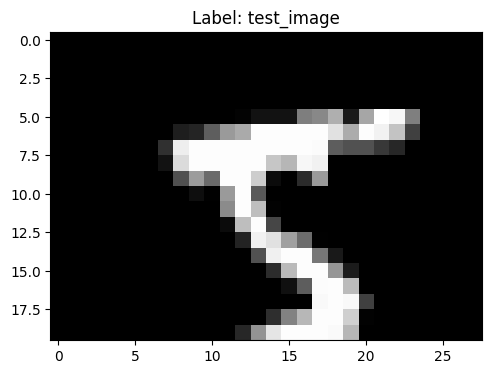

In [717]:
test_image = image.squeeze().numpy()[0:20,:]
print(test_image.shape)
plt.imshow(test_image, cmap='gray')
plt.title(f"Label: test_image")
plt.show()

In [761]:
# TEST Model init
mtest = ImageSegmentNet(2,3)
mtest.set_image(grayscale_array=test_image)
print(mtest.x)
print(mtest.y)
print(mtest.x_in.shape, mtest.y_in.shape)
#print(X.max(), Y.max())
#print(mtest.x)
#print(mtest.y)
mtest._calc_xmask()
mtest._calc_ymask()
ypred = mtest._predict_y()
mtest.xmask.shape,mtest.ymask.shape

Parameter containing:
tensor([[0.0000, 0.4107, 0.8214],
        [0.0000, 0.4107, 0.8214],
        [0.0000, 0.4107, 0.8214],
        [0.0000, 0.4107, 0.8214]], requires_grad=True)
Parameter containing:
tensor([[0.0000, 0.0000, 0.0000],
        [0.2262, 0.2262, 0.2262],
        [0.4524, 0.4524, 0.4524],
        [0.6786, 0.6786, 0.6786]], requires_grad=True)
torch.Size([20, 28]) torch.Size([28, 20])


(torch.Size([20, 28, 4, 2]), torch.Size([28, 20, 3, 3]))

In [768]:
print(mtest.x[0:1])
print(mtest.x_in[6:7,11:14])
print(mtest.x_in.shape,mtest.xmask.shape)
mask_val = mtest.xmask[6:7,11:14]
print(mask_val.shape)
print(mask_val)

# xmask looks fine

tensor([[0.0000, 0.4107, 0.8214]], grad_fn=<SliceBackward0>)
tensor([[0.3929, 0.4286, 0.4643]])
torch.Size([20, 28]) torch.Size([20, 28, 4, 2])
torch.Size([1, 3, 4, 2])
tensor([[[[ True, False],
          [ True, False],
          [ True, False],
          [ True, False]],

         [[False,  True],
          [False,  True],
          [False,  True],
          [False,  True]],

         [[False,  True],
          [False,  True],
          [False,  True],
          [False,  True]]]])


In [782]:
print(mtest.y[:,0:1])
print(mtest.y_in.shape,mtest.ymask.shape)
print(mtest.y_in[15:16,5:15])
mask_val = mtest.ymask[15:16,5:15]
print(mask_val.shape)
print(mask_val)
# ymask looks fine.

tensor([[0.0000],
        [0.2262],
        [0.4524],
        [0.6786]], grad_fn=<SliceBackward0>)
torch.Size([28, 20]) torch.Size([28, 20, 3, 3])
tensor([[0.0000, 0.2143, 0.2500, 0.2857, 0.0000, 0.0000, 0.0000, 0.0000, 0.4643,
         0.5000]])
torch.Size([1, 10, 3, 3])
tensor([[[[ True,  True,  True],
          [False, False, False],
          [False, False, False]],

         [[ True,  True,  True],
          [False, False, False],
          [False, False, False]],

         [[False, False, False],
          [ True,  True,  True],
          [False, False, False]],

         [[False, False, False],
          [ True,  True,  True],
          [False, False, False]],

         [[ True,  True,  True],
          [False, False, False],
          [False, False, False]],

         [[ True,  True,  True],
          [False, False, False],
          [False, False, False]],

         [[ True,  True,  True],
          [False, False, False],
          [False, False, False]],

         [[ True,  T

In [228]:
#Code modified for x,y parameters

class TwoDSegmentNet(nn.Module):
    def __init__(self, out_features, segment_features):
        super(TwoDSegmentNet, self).__init__()
        self.segment_features = segment_features
        self.out_features = out_features

        #Initialize x coordinates between 0-1 so segments are equal size
        x_init = torch.Tensor(np.linspace(0, 1, segment_features+1))
        # make a 2D init tensor
        x_2dinit = torch.Tensor(out_features, segment_features + 1)
        # Update the x_2dinit tensor with the repeated values
        x_2dinit[:] = x_init.unsqueeze(0)
        # initialize all rows of x
        self.x = nn.Parameter(torch.Tensor(x_2dinit))
        #y can be zeros
        self.y = nn.Parameter(torch.Tensor(out_features, segment_features + 1))

    def custom_init(self, x_min, x_max):
        x_init = torch.Tensor(np.linspace(x_min, x_max, self.segment_features+1))
        # make a 2D init tensor
        x_2dinit = torch.Tensor(self.out_features, self.segment_features + 1)
        # Update the x_2dinit tensor with the repeated values
        x_2dinit[:] = x_init.unsqueeze(0)
        # initialize all rows of x
        self.x = nn.Parameter(torch.Tensor(x_2dinit))
        #y_init = torch.Tensor(np.linspace(y_min, y_max, self.out_features))
        #y2d_init = torch.zeros_like(self.y)
        #y2d_init[:] = y_init.unsqueeze(1)
        # initialize all rows of y
        #self.y = nn.Parameter(y2d_init)
        #print("y2d_init:",y2d_init,"self.y:",self.y)

    
    def forward(self, x_in):
        # x_in.shape = [N, 1]
        x_in_4d =  x_in.unsqueeze(1).unsqueeze(1)     
        # x_in_4d.shape =  [N, 1, 1, 1] 
        # to find out if x is between segments
        lt = torch.lt(x_in_4d, self.x[:, 1:]) 
        ge = torch.ge(x_in_4d, self.x[:, :-1]) 
        mask = (lt & ge)

        # This mask doesn't include x where x is below 1st segment start or after last segment end
        # we create new mask to capture the x values beyond segments
        mask_lt = torch.lt(x_in_4d,self.x[:, 0:1])
        mask_ge = torch.ge(x_in_4d,self.x[:, -1:])
        # then do OR with mask so these are included for prediction.
        mask[:,:,:,-1:] = mask[:,:,:,-1:] | mask_ge
        mask[:,:,:, :1] = mask[:,:,:, :1] | mask_lt

        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        # consider each segment as a right triangle so we can find new y-y1 as ratio of x-x1
        ratio = (self.y[:,1:]-self.y[:,:-1])/(self.x[:,1:]-self.x[:,:-1])

        ypred = (x_in_4d -  self.x[:,:-1])*mask*ratio + mask * self.y[:,:-1]
        ypred = ypred.sum(dim=3)
        #print("ypred.shape:",ypred.shape)
        return ypred
            
    def extra_repr(self) -> str:
        return f'out_features={self.out_features}, segment_features={self.segment_features}'

## 2dmodel testing

In [520]:
xs = np.arange(-1.5, 11., .05)
ys = f_quartic(xs)
print(xs.shape, ys.shape)

x = torch.tensor((xs).reshape(xs.shape[0],1), dtype=torch.float32)
y = torch.tensor((ys).reshape(ys.shape[0],1), dtype=torch.float32) # y is from function / not randomized

(250,) (250,)


In [523]:
model1 = TwoDSegmentNet(1, 4)
layers = 2
model2 = TwoDSegmentNet(layers, 4)
x_in = x[-3:,:]
y_out = y[-3:,:]
print(x_in,"\n", y_out)
print(model1.x.shape, "\n",model2.x.shape)
print(model1.x, "\n", model2.x)

tensor([[10.8500],
        [10.9000],
        [10.9500]]) 
 tensor([[-1.2403],
        [-1.7068],
        [-2.1912]])
torch.Size([1, 5]) 
 torch.Size([2, 5])
Parameter containing:
tensor([[0.0000, 0.2500, 0.5000, 0.7500, 1.0000]], requires_grad=True) 
 Parameter containing:
tensor([[0.0000, 0.2500, 0.5000, 0.7500, 1.0000],
        [0.0000, 0.2500, 0.5000, 0.7500, 1.0000]], requires_grad=True)


In [524]:
print(y_out.shape,"\n", y_out)
y_out2 = torch.rand(y_out.shape[0], y_out.shape[1], layers)
print(y_out2.shape)
y_out2[:] = y_out.unsqueeze(1)
print(y_out2)

torch.Size([3, 1]) 
 tensor([[-1.2403],
        [-1.7068],
        [-2.1912]])
torch.Size([3, 1, 2])
tensor([[[-1.2403, -1.2403]],

        [[-1.7068, -1.7068]],

        [[-2.1912, -2.1912]]])


In [525]:
# init
model1.x = torch.nn.Parameter(torch.Tensor(np.linspace(x.min(), x.max(), model1.segment_features+1)))
x_init = torch.Tensor(np.linspace(x.min(), x.max(), model2.segment_features+1))
# make a 2D init tensor
x_2dinit = torch.Tensor(model2.out_features, model2.segment_features + 1)
# Update the x_2dinit tensor with the repeated values
x_2dinit[:] = x_init.unsqueeze(0)
# initialize all rows of x
model2.x = nn.Parameter(torch.Tensor(x_2dinit))

print(model1.x.shape, "\n",model2.x.shape)
print(model1.x, "\n", model2.x)

torch.Size([5]) 
 torch.Size([2, 5])
Parameter containing:
tensor([-1.5000,  1.6125,  4.7250,  7.8375, 10.9500], requires_grad=True) 
 Parameter containing:
tensor([[-1.5000,  1.6125,  4.7250,  7.8375, 10.9500],
        [-1.5000,  1.6125,  4.7250,  7.8375, 10.9500]], requires_grad=True)


In [526]:
model2.custom_init(x.min(), x.max())
print(model2.x.shape, "\n", model2.x)

torch.Size([2, 5]) 
 Parameter containing:
tensor([[-1.5000,  1.6125,  4.7250,  7.8375, 10.9500],
        [-1.5000,  1.6125,  4.7250,  7.8375, 10.9500]], requires_grad=True)


In [529]:
x_in_4d =  x_in.unsqueeze(1).unsqueeze(1) 
print(x_in.unsqueeze(1).shape, x_in_4d.shape)
lt = torch.lt(x_in.unsqueeze(1), model1.x[1:]) 
print(lt.shape,"\n", lt)
lt4 = torch.lt(x_in_4d, model2.x[:,1:]) 
print(lt4.shape,"\n", lt4)

torch.Size([3, 1, 1]) torch.Size([3, 1, 1, 1])
torch.Size([3, 1, 4]) 
 tensor([[[False, False, False,  True]],

        [[False, False, False,  True]],

        [[False, False, False, False]]])
torch.Size([3, 1, 2, 4]) 
 tensor([[[[False, False, False,  True],
          [False, False, False,  True]]],


        [[[False, False, False,  True],
          [False, False, False,  True]]],


        [[[False, False, False, False],
          [False, False, False, False]]]])


In [ ]:
ge = torch.ge(x_in.unsqueeze(1), model1.x[:-1]) 
print(ge.shape,"\n", ge)
ge4 = torch.ge(x_in_4d, model2.x[:,:-1]) 
print(ge4.shape,"\n", ge4)

torch.Size([3, 1, 4]) 
 tensor([[[True, True, True, True]],

        [[True, True, True, True]],

        [[True, True, True, True]]])
torch.Size([3, 1, 2, 4]) 
 tensor([[[[True, True, True, True],
          [True, True, True, True]]],


        [[[True, True, True, True],
          [True, True, True, True]]],


        [[[True, True, True, True],
          [True, True, True, True]]]])


In [ ]:
mask = (lt & ge)
print(mask.shape,"\n", mask)
mask4 = (lt4 & ge4)
print(mask4.shape,"\n",mask4)

torch.Size([3, 1, 4]) 
 tensor([[[False, False, False,  True]],

        [[False, False, False,  True]],

        [[False, False, False, False]]])
torch.Size([3, 1, 2, 4]) 
 tensor([[[[False, False, False,  True],
          [False, False, False,  True]]],


        [[[False, False, False,  True],
          [False, False, False,  True]]],


        [[[False, False, False, False],
          [False, False, False, False]]]])


In [ ]:
mask_lt = torch.lt(x_in.unsqueeze(1),model1.x[0:1])
print(mask_lt.shape, "\n", mask_lt)
mask_lt4 = torch.lt(x_in_4d,model2.x[:, 0:1])
print(mask_lt4.shape, "\n", mask_lt4)

torch.Size([3, 1, 1]) 
 tensor([[[False]],

        [[False]],

        [[False]]])
torch.Size([3, 1, 2, 1]) 
 tensor([[[[False],
          [False]]],


        [[[False],
          [False]]],


        [[[False],
          [False]]]])


In [ ]:
mask_ge = torch.ge(x_in.unsqueeze(1),model1.x[-1:])
print(mask_ge.shape, "\n", mask_ge)
mask_ge4 = torch.ge(x_in_4d,model2.x[:, -1:])
print(mask_ge4.shape, "\n", mask_ge4)

torch.Size([3, 1, 1]) 
 tensor([[[False]],

        [[False]],

        [[ True]]])
torch.Size([3, 1, 2, 1]) 
 tensor([[[[False],
          [False]]],


        [[[False],
          [False]]],


        [[[ True],
          [ True]]]])


In [ ]:
mask[:,:,-1:] = mask[:,:,-1:] | mask_ge
mask[:,:,:1] = mask[:,:,:1] | mask_lt
print(mask.shape,"\n", mask)
mask4[:,:,:,-1:] = mask4[:,:,:,-1:] | mask_ge4
mask4[:,:,:,:1] = mask4[:,:,:,:1] | mask_lt4
print(mask4.shape,"\n", mask4)

torch.Size([3, 1, 4]) 
 tensor([[[False, False, False,  True]],

        [[False, False, False,  True]],

        [[False, False, False,  True]]])
torch.Size([3, 1, 2, 4]) 
 tensor([[[[False, False, False,  True],
          [False, False, False,  True]]],


        [[[False, False, False,  True],
          [False, False, False,  True]]],


        [[[False, False, False,  True],
          [False, False, False,  True]]]])


In [ ]:
ratio = (model1.y[1:]-model1.y[:-1])/(model1.x[1:]-model1.x[:-1])
print(ratio.shape, "\n", ratio)
ratio4 = (model2.y[:,1:]-model2.y[:,:-1])/(model2.x[:,1:]-model2.x[:,:-1])
print(ratio4.shape, "\n", ratio4)

torch.Size([4]) 
 tensor([0., 0., 0., 0.], grad_fn=<DivBackward0>)
torch.Size([2, 4]) 
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]], grad_fn=<DivBackward0>)


In [ ]:
ypred = (x_in.unsqueeze(1) -  model1.x[:-1])*mask*ratio + mask * model1.y[:-1]
ypred = ypred.sum(dim=2)
print(ypred.shape, "\n", ypred)
ypred4 = (x_in_4d -  model2.x[:,:-1])*mask4*ratio4 + mask4 * model2.y[:,:-1]
ypred4 = ypred4.sum(dim=3)
print(ypred4.shape, "\n", ypred4)

torch.Size([3, 1]) 
 tensor([[0.],
        [0.],
        [0.]], grad_fn=<SumBackward1>)
torch.Size([3, 1, 2]) 
 tensor([[[0., 0.]],

        [[0., 0.]],

        [[0., 0.]]], grad_fn=<SumBackward1>)


In [ ]:
loss = criterion(ypred, y_out)
loss4= criterion(ypred4, y_out2)
print(loss, "\n", loss4)

tensor(9.2526, grad_fn=<MseLossBackward0>) 
 tensor(18.5053, grad_fn=<MseLossBackward0>)


In [ ]:
model1.zero_grad(set_to_none=True)
loss.backward()
print(model1.x, "\n", model1.y)
model2.zero_grad(set_to_none=True)
loss4.backward()
print(model2.x, "\n", model2.y)

Parameter containing:
tensor([-1.5000,  1.6125,  4.7250,  7.8375, 10.9500], requires_grad=True) 
 Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True)
Parameter containing:
tensor([[-1.5000,  1.6125,  4.7250,  7.8375, 10.9500],
        [-1.5000,  1.6125,  4.7250,  7.8375, 10.9500]], requires_grad=True) 
 Parameter containing:
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], requires_grad=True)


In [ ]:
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=.001, betas=(0.9, 0.999), eps=1e-8)

optimizer2 = torch.optim.AdamW(model2.parameters(), lr=.001, betas=(0.9, 0.999), eps=1e-8)


In [ ]:
optimizer1.step()
print(model1.x, "\n", model1.y)
optimizer2.step()
print(model2.x, "\n", model2.y)

Parameter containing:
tensor([-1.5000,  1.6125,  4.7250,  7.8374, 10.9499], requires_grad=True) 
 Parameter containing:
tensor([ 0.0000,  0.0000,  0.0000, -0.0010, -0.0010], requires_grad=True)
Parameter containing:
tensor([[-1.5000,  1.6125,  4.7250,  7.8374, 10.9499],
        [-1.5000,  1.6125,  4.7250,  7.8374, 10.9499]], requires_grad=True) 
 Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000, -0.0010, -0.0010],
        [ 0.0000,  0.0000,  0.0000, -0.0010, -0.0010]], requires_grad=True)


## OneLayerSegmentNet Model Def

In [ ]:
#Code modified for x,y parameters

class OneLayerSegmentNet(nn.Module):
    def __init__(self, out_features, segment_features):
        super(OneLayerSegmentNet, self).__init__()
        self.segment_features = segment_features
        self.out_features = out_features
        
        #Initialize x coordinates between 0-1 so segments are equal size
        x_init = torch.Tensor(np.linspace(0, 1., segment_features+1))
        #x_init = torch.arange(0, 1 + 1./segment_features, 1/segment_features)
        # make sure x_init shape is segment + 1 as it can be more for some segment_features like 6
        #x_init = x_init[0:1+segment_features]
        # make a 2D init tensor
        #x_2dinit = torch.Tensor(out_features, segment_features + 1)
        # Update the x_2dinit tensor with the repeated values
        #x_2dinit[:] = x_init.unsqueeze(0)
        # initialize all rows of x
        self.x = nn.Parameter(torch.Tensor(x_init))
        #y can be zeros
        self.y = nn.Parameter(torch.Tensor(segment_features + 1))
        #print("self.x.shape",self.x.shape)
        #print("self.y.shape",self.y.shape)

    def custom_init(self, x_min, x_max):
        self.x = torch.nn.Parameter(torch.Tensor(np.linspace(x_min, x_max, self.segment_features+1)))   
    
    def forward(self, x_in):
        #print("x_in.shape:",x_in.shape)        
        # to find out if x is between segments
        lt = torch.lt(x_in.unsqueeze(1), self.x[1:]) 
        ge = torch.ge(x_in.unsqueeze(1), self.x[:-1]) 
        mask = (lt & ge)
        #print("mask.shape:",mask.shape)

        # This mask doesn't include x where x is below 1st segment start or after last segment end
        # we create new mask to capture the x values beyond segments
        mask_lt = torch.lt(x_in.unsqueeze(1),self.x[0:1])
        mask_gt = torch.ge(x_in.unsqueeze(1),self.x[-1:])
        # then do OR with mask so these are included for prediction.
        mask[:,:,-1:] = mask[:,:,-1:] | mask_gt
        mask[:,:,:1] = mask[:,:,:1] | mask_lt
        #print("mask:", mask)

        # Ratio is the segment (y2-y1)/(x2-x1) ratio 
        # consider each segment as a right triangle so we can find new y-y1 as ratio of x-x1
        ratio = (self.y[1:]-self.y[:-1])/(self.x[1:]-self.x[:-1])
        #print("ratio:",ratio)

        ypred = (x_in.unsqueeze(1) -  self.x[:-1])*mask*ratio + mask * self.y[:-1]
        ypred = ypred.sum(dim=2)
        #print("ypred.shape:",ypred.shape)
        return ypred
            
    def extra_repr(self) -> str:
        return f'out_features={self.out_features}, segment_features={self.segment_features}'

# Data Loaders

In [18]:
from torch.utils.data.dataloader import DataLoader

class InfiniteRandomDataLoader:

    def __init__(self, dataset, loss, replacement=True, **kwargs):
        train_sampler = torch.utils.data.RandomSampler(dataset, replacement=replacement, num_samples=int(1e10))
        self.train_loader = DataLoader(dataset, sampler=train_sampler, **kwargs)
        self.data_iter = iter(self.train_loader)

    def next(self):
        try:
            batch = next(self.data_iter)
        except StopIteration: # this will technically only happen after 1e10 samples... (i.e. basically never)
            self.data_iter = iter(self.train_loader)
            batch = next(self.data_iter)
        return batch


## Model helper functions

In [ ]:
def get_model_param_grad(model):
    dt = {}
    for param in model.parameters():
        if(param.shape == (model.segment_features,1)):
            dt['weight_grad'] = param.grad
        else:
            dt['bias_grad'] = param.grad
    return dt

# Model Training with random data loader

In [ ]:
# test data

f = f2_quartic # select data function
xs = np.arange(-1.5, 11., .05)
ys2 = f(xs)
ys = np.array(ys2)
ys[:,0] = ys2.min(axis=1)
ys[:,1] = ys2.max(axis=1)

x = torch.tensor((xs).reshape(xs.shape[0],1), dtype=torch.float32)
#ytest = torch.tensor((ys).reshape(ys.shape[0],1), dtype=torch.float32) # y is from function / not randomized
ytest = torch.tensor((ys).reshape(ys.shape[0],1,ys.shape[1]), dtype=torch.float32)
print(ytest.shape)
mu_x = torch.mean(x)
std_x = torch.std(x)

mu_y = torch.mean(ytest)
std_y = torch.std(ytest)
print(mu_y.shape)

x_normalized = torch.nn.functional.normalize(x, dim=0)
y_normalized = torch.nn.functional.normalize(ytest, dim=0)
print(y_normalized.shape)
#x, ytest = normalize(x, ytest)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.plot(x_normalized, y_normalized[:,0,0])
ax2.plot(x_normalized, y_normalized[:,0,1])
ax1.plot(xs,ys)
#ax2.scatter(x, yout[:,0,0], color='red', s=1)
#ax2.scatter(x, yout[:,0,1], color='green', s=1)
plt.show()

# Init

In [230]:
# init training
import time
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

torch.manual_seed(10)

#model = OneLayerSegmentNet(1, 4)
model = TwoDSegmentNet(2, 9)
criterion = nn.MSELoss(reduction='sum')

# Capture params after initialization
model_params = []
#model_param_grads = []
model_params.append(copy.deepcopy(model.state_dict()))

#create ys data from scratch so we can sort xs as needed - made no different with randomloader for segmentnet
f = f2_quartic # select data function
xs = np.arange(-1.5, 11., .05)
ys2 = f(xs)
ys = np.array(ys2)
ys[:,0] = ys2.min(axis=1)
ys[:,1] = ys2.max(axis=1)
print(xs.shape, ys.shape)

x = torch.tensor((xs).reshape(xs.shape[0],1), dtype=torch.float32)
#ytest = torch.tensor((ys).reshape(ys.shape[0],1), dtype=torch.float32) # y is from function / not randomized
ytest = torch.tensor((ys).reshape(ys.shape[0],1,ys.shape[1]), dtype=torch.float32)
print(ytest.shape)

#normalization - important
x, ytest = normalize(x, ytest)

#Initialize model parameters - extremely important
model.custom_init(x.min(), x.max())

dataLoader = InfiniteRandomDataLoader

# create dataset that can be used in a dataloader 
dataset = torch.utils.data.TensorDataset(x, ytest)

#initialize training params
step = 0
losses = np.array([])
with torch.no_grad():
    y = model(x)
    total_mean_loss = criterion(y, ytest)
#    losses = np.append(losses, total_mean_loss)

lr=.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-8)
#scheduler = ReduceLROnPlateau(optimizer, 'min', factor=.5, patience=100,threshold=0.1, threshold_mode='rel', cooldown=0, 
#                                                 min_lr=0, eps=1e-08, verbose=True) # let us try scheduler to reduce learning rate

(250,) (250, 2)
torch.Size([250, 1, 2])


In [231]:
model.x, model.y

(Parameter containing:
 tensor([[-0.0160, -0.0012,  0.0135,  0.0282,  0.0429,  0.0576,  0.0723,  0.0871,
           0.1018,  0.1165],
         [-0.0160, -0.0012,  0.0135,  0.0282,  0.0429,  0.0576,  0.0723,  0.0871,
           0.1018,  0.1165]], requires_grad=True),
 Parameter containing:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True))

## Training loop

In [232]:
# training loop

max_steps = 2000
best_val_loss = 100
early_stop_patience = 3 # Stop training loop if val_los > best_val_loss this many times

model.train() # We use this variable for training
# init dataloader
batch_loader = dataLoader(dataset,loss=total_mean_loss,replacement=False, batch_size=64, pin_memory=True, num_workers=1)

while True:
    t0 = time.time()
    # get the next batch, ship to device, and unpack it to input and target
    X, Y = batch_loader.next()
    #check for NaN
    if math.isnan(Y.mean()):
        print ("Breaking for NaN")
        break

    # Forward pass
    ypred = model(X)
    # Calculate the loss
    loss = criterion(ypred, Y)
    
    # Backward and optimize
    model.zero_grad(set_to_none=True)
    loss.backward()

    # Validate model after this optimizer.step
    # we validate on complete data
    with torch.no_grad():
        y = model(x)
        #y = y.squeeze(2) ### TEMPORARY
        total_mean_loss = criterion(y, ytest)
    losses = np.append(losses, total_mean_loss)

    optimizer.step() #Definitely needed
    step += 1
    #scheduler.step(total_mean_loss)
    t1 = time.time()

    # store params (weights and biases) after each training step
    if step % 10 == 0:
        model_params.append(copy.deepcopy(model.state_dict()))
        #model_param_grads.append(get_model_param_grad(model))
             
    # print logging
    if step % 100 == 0:         
        print(f"step {step} | loss {loss:.4f} | total_mean_loss {total_mean_loss:.4f} | step time {(t1-t0)*1000:.2f}ms")

    # termination conditions
    if total_mean_loss < best_val_loss:
        early_stop_patience = 1000 # max value
        best_val_loss = total_mean_loss
    else:
        early_stop_patience -= 1
        if early_stop_patience == 0 or best_val_loss <= .0022:
            print("Can terminating due to early_stop_patience at step ",step, " best_val_loss:",best_val_loss)
            #break
        
    if step >= max_steps:
        break

print("best_val_loss:",best_val_loss,"last_total_loss:",total_mean_loss, "early_stop_patience:",early_stop_patience," step:",step)

step 100 | loss 0.3391 | total_mean_loss 1.2175 | step time 1.19ms
step 200 | loss 0.2148 | total_mean_loss 0.8307 | step time 0.78ms
step 300 | loss 0.1015 | total_mean_loss 0.6007 | step time 0.78ms
step 400 | loss 0.1060 | total_mean_loss 0.4339 | step time 0.75ms
step 500 | loss 0.0712 | total_mean_loss 0.3117 | step time 0.73ms
step 600 | loss 0.0491 | total_mean_loss 0.2222 | step time 0.73ms
step 700 | loss 0.0411 | total_mean_loss 0.1571 | step time 0.81ms
step 800 | loss 0.0279 | total_mean_loss 0.1097 | step time 0.75ms
step 900 | loss 0.0215 | total_mean_loss 0.0757 | step time 0.75ms
step 1000 | loss 0.0100 | total_mean_loss 0.0515 | step time 0.77ms
step 1100 | loss 0.0077 | total_mean_loss 0.0349 | step time 0.75ms
step 1200 | loss 0.0057 | total_mean_loss 0.0233 | step time 0.80ms
step 1300 | loss 0.0034 | total_mean_loss 0.0158 | step time 0.89ms
step 1400 | loss 0.0036 | total_mean_loss 0.0121 | step time 0.76ms
step 1500 | loss 0.0024 | total_mean_loss 0.0084 | step t

last total_mean_loss  tensor(0.0040)


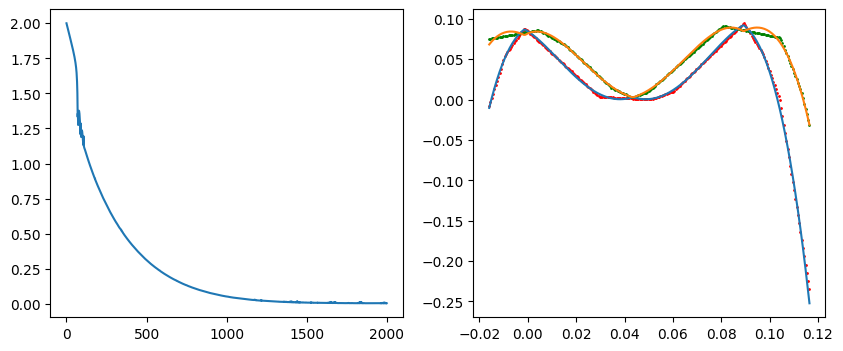

In [233]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 4) # this is done to increase width to 

# Create a figure and two axes objects
# Increase the figure size to accommodate wider plots
fig, (ax1, ax2) = plt.subplots(1, 2)

# plot loss
print ("last total_mean_loss ",total_mean_loss)
ax1.plot(losses)

# plot trained model
y = model(x)
yout = y.detach().numpy()
ax2.plot(x, ytest[:,0,0])
ax2.plot(x, ytest[:,0,1])
ax2.scatter(x, yout[:,0,0], color='red', s=1)
ax2.scatter(x, yout[:,0,1], color='green', s=1)

# Display the plot
plt.show()

In [202]:
# Save graph to a file
#!pip install torchviz
from torchviz import make_dot

# Generate a Graphviz object from the computation graph
graph = make_dot(loss, params=dict(model.named_parameters())) 

# Save the graph as a PDF or any other format if needed
graph.render("model_TwoDSegmentNet_v2_graph")

'model_TwoDSegmentNet_v2_graph.pdf'

Text(0.5, 1.0, 'Are segment x in ascending order?')

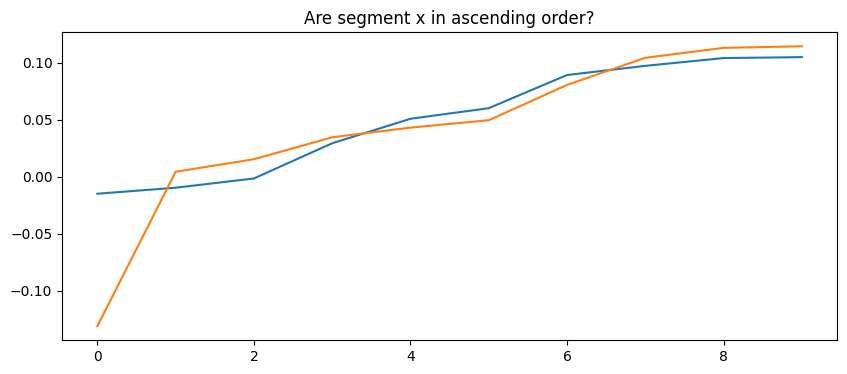

In [211]:
# Are x in ascending order?
plt.plot(np.arange(model_params[-1]['x'].shape[1]), model_params[-1]['x'][0])
plt.plot(np.arange(model_params[-1]['x'].shape[1]), model_params[-1]['x'][1])
plt.title("Are segment x in ascending order?")

In [595]:
model_params[-1]['x'][0]

tensor([-0.1008, -0.0936, -0.0728, -0.0163,  0.0108,  0.0696,  0.0913,  0.0984])

Text(0.5, 1.0, 'How the segments connect')

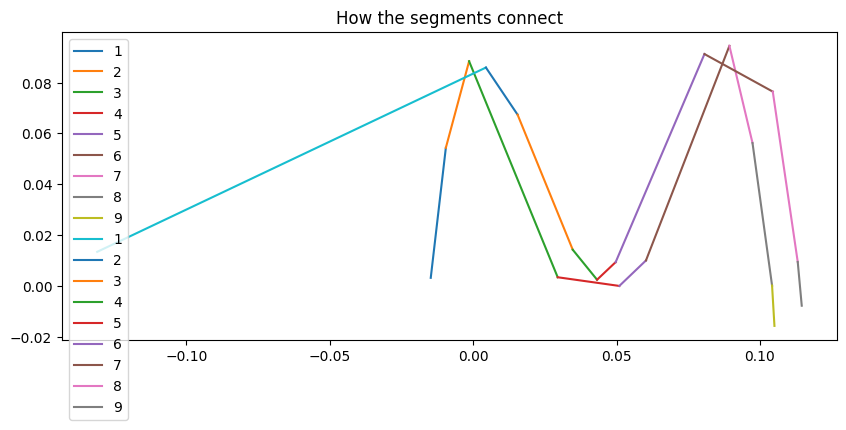

In [212]:
for seg in np.arange(model_params[-1]['x'].shape[1]-1):
 plt.plot(model_params[-1]['x'][0,seg:seg+2],model_params[-1]['y'][0,seg:seg+2],label=seg+1)    

for seg in np.arange(model_params[-1]['x'].shape[1]-1):
 plt.plot(model_params[-1]['x'][1,seg:seg+2],model_params[-1]['y'][1,seg:seg+2],label=seg+1)  
#plt.plot(model_params[-1]['x'],model_params[-1]['y']) 
plt.legend()
plt.title("How the segments connect")

# Show training as animation

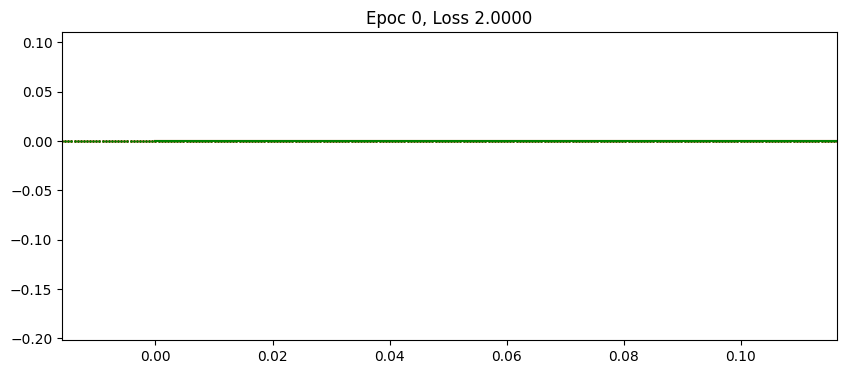

In [213]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.set_xlim(x.min(), x.max())
ax.set_ylim(ytest.min()*.8, ytest.max()*1.2)
ax2.plot(x, ytest[:,0,0])
ax2.plot(x, ytest[:,0,1])
scatter = ax.scatter([], [], c='r',s=1)
scatter2 = ax.scatter([], [], c='g',s=1)
a1 = ax.plot([], [], c='r', linestyle="-")
a2 = ax.plot([], [], c='g', linestyle="-")

def animate(i):
    model.load_state_dict(model_params[i])
    px = model_params[i]['x']
    py = model_params[i]['y']
    a1[0].set_data(px[0], py[0])
    a2[0].set_data(px[1], py[1])

    #alternate plot
    with torch.no_grad():
        model.eval() # be sure to call model.eval() method before inferencing to set the dropout and batch normalization layers to evaluation mode. Failing to do this will yield inconsistent inference results.
        y = model(x)
    yout = y.detach().numpy()
    scatter.set_offsets(np.column_stack((x, yout[:,0,0])))
    scatter2.set_offsets(np.column_stack((x, yout[:,0,1])))
    ax.set_title(f"Epoc {i*1}, Loss {losses[10*(i)]:.4f}")
    return 

anim = FuncAnimation(fig, animate, frames=range(0,len(model_params)-1, 10))

In [214]:
from IPython.display import HTML
HTML(anim.to_jshtml())

501

# Debug Zone

In [430]:
#model parameters under consideration
i = -1
model_params[i]

OrderedDict([('x', tensor([-0.1205, -0.0026,  0.0168,  0.0746])),
             ('y', tensor([ 0.0625, -0.0472, -0.0357,  0.0958]))])

In [433]:
# which X values are below segment range
x_below = x[x<model_params[i]['x'][0]]
x_below

tensor([])

In [460]:
# which X values are above segment range
x_above = x[x>model_params[i]['x'][-1]]
x_above

tensor([0.0749, 0.0758, 0.0767, 0.0776, 0.0784, 0.0793, 0.0802, 0.0811, 0.0819,
        0.0828, 0.0837, 0.0846, 0.0854, 0.0863, 0.0872, 0.0881, 0.0890, 0.0898,
        0.0907, 0.0916, 0.0925, 0.0933, 0.0942, 0.0951, 0.0960, 0.0968, 0.0977,
        0.0986, 0.0995, 0.1003, 0.1012, 0.1021, 0.1030, 0.1038, 0.1047, 0.1056,
        0.1065, 0.1074, 0.1082, 0.1091])

In [477]:
#Let us take a subset of values to study
x_in = x_above[0:2]
x_in = x_in.unsqueeze(-1)
x_in

tensor([[0.0749],
        [0.0758]])

In [496]:
# what is the model predicting 
model.load_state_dict(model_params[i])
with torch.no_grad():
    model.eval() 
    ypred = model(x_in)


In [497]:
ypred

tensor([[-0.0240],
        [-0.0223]])

## redo forward method step by step

In [481]:
#Find the mask
lt = torch.lt(x_in.unsqueeze(1), model_params[i]['x'][1:]) 
ge = torch.ge(x_in.unsqueeze(1), model_params[i]['x'][:-1]) 
mask = (lt & ge)
mask.shape, mask

(torch.Size([2, 1, 3]),
 tensor([[[False, False, False]],
 
         [[False, False, False]]]))

In [499]:
# modify the mask for x out of segment boundary
mask_lt = torch.lt(x_in.unsqueeze(1),model_params[i]['x'][0:1])
mask_gt = torch.ge(x_in.unsqueeze(1),model_params[i]['x'][-1:])
# then do OR with mask so these are included for prediction.
mask[:,-1:] = mask[:,:,-1:] | mask_gt
mask[:,:1] = mask[:,:,:1] | mask_lt
#mask[:,:,-1:] = mask[:,:,-1:] | mask_gt
#mask[:,:,:1] = mask[:,:,:1] | mask_lt
mask

tensor([[[True, True, True]],

        [[True, True, True]]])

In [500]:
#ypred = (x_in.unsqueeze(1) -  self.x[:-1])*mask*ratio + mask * self.y[:-1]
ratio = (model_params[i]['y'][1:]-model_params[i]['y'][:-1])/(model_params[i]['x'][1:]-model_params[i]['x'][:-1])
ratio

tensor([-0.9306,  0.5918,  2.2761])

In [501]:
ycalc = (x_in.unsqueeze(1) - model.x[:-1])*mask*ratio + mask * model.y[:-1]
ycalc = ycalc.sum(dim=2)
ycalc, ypred

(tensor([[-0.0240],
         [-0.0223]], grad_fn=<SumBackward1>),
 tensor([[-0.0240],
         [-0.0223]]))